# Root Finding: Method of False Position (*Regula Falsi*)
---

GENERAL PROBLEM: find the real roots of a given function $f(x)$ in the case when closed-form solutions are not available. That is, find the values of $x$ that satisfy the equation

\begin{align}
  f(x) = 0
\end{align}

where $x$ is a real variable, and $f(x)$ is some non-linear function.

IDEA: similar to the secant method, use the roots of secant lines to construct successive approximations to the actual root of the function, but always keeping the root bracketed (as in the bisection method). 

PRE-REQUISITES:
- Bisection method
- Secant method

REFERENCES:
- [1] Burden and Faires, *Numerical Analysis, 7th edition*.
- [2] Ralston and Rabinowitz, *A First Course in Numerical Analysis, 2nd edition*.
- [3] Press et al, *Numerical Recipes: the Art of Scientific Computing, 3rd edition*.
- [4] Stoer and Bulirsch, *Introduction to Numerical Analysis, 2nd edition*.

## 1. Summary of the method

Method of false position is a hybrid between the bisection and secant methods. As with the secant method, we generate successive approximations to the root of $f(x)$ using the roots of secant lines. However, unlike the secant method, the method of false position keeps the actual root bracketed. Recall that the secant method always uses the previous two approximations to generate the next approximation, regardless of whether they bracket the root. In contrast, the method of false position performs a sign test in order to keep the root bracketed (similar to the bisection method).   

As before, we assume that we have identified an interval $[a,b]$ that brackets a root of $f(x)$.
 
To start the method, let $a_{0}=a$ and $b_{0}=b$. The equation for the line that passes through points $(a_{0}, f(a_{0}))$ and $(b_{0}, f(b_{0}))$ is

\begin{align}
  g_{1}(x) = \frac{(x - b_{0})}{(a_{0} - b_{0})}f(a_{0}) 
  + \frac{(x - a_{0})}{(b_{0} - a_{0})}f(b_{0}).
\end{align}

We take the next bracketing end point to be where this line crosses zero, namely

\begin{align}
  p_{1} = b_{0} - f(b_{0})\frac{b_{0} - a_{0}}{f(b_{0}) - f(a_{0})}
  = \frac{a_{0}}{f(b_{0}) - f(a_{0})}f(b_{0}) + \frac{b_{0}}{f(a_{0}) - f(b_{0})}f(a_{0}).
\end{align}

(PROGRAMMER'S NOTE: the second form is prefered over the first, because it avoids loss of significant figures that may stem from the subtraction $b_{0}-a_{0}$. In later iterations, as the solution is approached, $b_{i}-a_{i}$ may give rise to significant roundoff error.)

We then perform a sign test, as in the bisection method. If the root lies in the left interval, set $[a_{1},b_{1}]=[a_{0},p_{1}]$. If the root lies inthe right interval, set $[a_{1},b_{1}]=[p_{1},b_{0}]$.

During the $i$th iteration, the secant line generated by the previous two approximants is

\begin{align}
  g_{i+1}(x) = \frac{(x - b_{i})}{(a_{i} - b_{i})}f(a_{i}) 
  + \frac{(x - a_{i})}{(b_{i} - a_{i})}f(b_{i}).
\end{align}

whose root provides the next bracketing end point

\begin{align}
  p_{i+1} = \frac{a_{i}}{f(b_{i}) - f(a_{i})}f(b_{i}) 
  + \frac{b_{i}}{f(a_{i}) - f(b_{i})}f(a_{i}).
\end{align}

As in the secant method, we take the relative uncertainty in the location of the root at the end of an iteration to be

\begin{align}
  \mathsf{REL}
  = \left|\frac{\text{(current approximant)} - \text{(previous approximant)}}{\text{(current approximant)}}\right|
  = \left|\frac{p_{i+1} - p_{i}}{p_{i+1}}\right|
\end{align}

We also calculate the error  

\begin{align}
  \mathsf{ABS} = \left|f(p_{i+1})\right|
\end{align}

In the algorithm below, the process of searching for a root continues until both of these errors are less than some specified tolerance (or the maximum allowed number of iterations is reached).

The method of false position converges somewhat slower than secant method, but faster than the bisection method. As with the secant method, it improves convergence by using secant lines rather than bisecting the interval at each step. This allows for larger jumps toward the root at each iteration. However, the method is somewhat cautious by demanding that the root remain bracketed. This avoids the runaway issues that can plague the secant method, at the expense of speed. See below for two refinements of the method of false position (called Illinois and Pegasus methods).

## 2. Algorithm

**INPUT**
- an interval $[a,b]$ where a root of the function in question is known to exist.
- TOL, the relative error tolerance that the answer is required to have.
- $i_\mathrm{max}$, maximum number of iterations allowed.

**Validate initial interval**
- if $\phi(a,b) \geq 0$, complain and quit. Otherwise continue.

**Initialize loop**
- set $i = 0$
- set $a_{0}=a$ and $b_{0}=b$
- set $p_{0}=b$

**Loop** while $i \leq i_\mathrm{max}$


- calculate root of the secant line: $p_{i+1} = b_{i} - f(b_{i})(b_{i} - a_{i})/(f(b_{i}) - f(a_{i}))$


- calculate the relative uncertainty using:  REL $= \left|(p_{i+1} - p_{i})/p_{i+1}\right|$


- calculate ABS $= |f(p_{i+1})|$


- if (REL $\leq$ TOL) and (ABS $\leq$ TOL), stop. Otherwise, continue.


- determine which subinterval the root lies in, and update end points
  - calculate $\phi(a_{i},p_{i+1}) = \mathrm{sgn}(f(a_{i}))\mathrm{sgn}(f(p_{i+1}))$.
  - if $\phi(a_{i},p_{i+1}) < 0$, set $a_{i+1}=a_{i}$ and $b_{i+1}=p_{i+1}$
  - if $\phi(a_{i},p_{i+1}) > 0$, set $a_{i+1}=p_{i+1}$ and $b_{i+1}=b_{i}$
  - if $\phi(a_{i},p_{i+1}) = 0$, stop


- i = i + 1


**Max iterations reached**
- Print message that max iterations have been reached, and stop.

**OUTPUT**

root found, or message of failure

## 3. CODE:

In [1]:
%%writefile false_position.py
import numpy as np
import sys
def false_position(f, a, b, TOL, imax):
    """
    Function that searches for roots of f(x) using the method of false position.
    
    INPUT
    f    : function whose roots are being sought 
    a    : initial left end point
    b    : initial right end point
    TOL  : allowed tolerance
    imax : maximum number of iterations
    
    OUTPUT
    location of the root to within the allowed tolerance, or failure message
    """
    
    # test initial bracket 
    if np.sign(f(a))*np.sign(f(b)) > 0:
        # if sgn > 0, problem may not be well-defined
        print('WARNING: function has the same sign at both ends of the interval.')
        print('This may lead to convergence problems. Proceed with caution!')

    # initialize iteration
    xLeft = a   # set left bound
    xRight = b  # set right bound
    pOld = b # set zeroth approximant
    
    # iterate search using method of false position
    i = 0  # reset iteration number
    while i <= imax:
    
                
        # update approximate location of root
        pNew = xRight - f(xRight)*(xRight - xLeft)/(f(xRight) - f(xLeft))
        print('iteration',i,': approximate location of root at',pNew)
    
        # calculate errors
        xErr = np.abs((pNew - pOld)/pNew)
        fErr = f(pNew)

        # check if errors are within the allowed tolerance
        if (xErr <= TOL and fErr <= TOL):
            best = pNew #best estimate
            delta = np.abs(pNew-pOld) #uncertainty
            print('SUCCESS! Root has been located to within the specified tolerance after',i,'iterations.')
            print('Root is located at',best,'+/-',delta)
            return

        # determine which subinterval the root lies in, and update end points      
        sgn = np.sign(f(xLeft))*np.sign(f(pNew))
        if sgn <= 0:
            # if sgn < 0, root is in left subinterval,
            # make midpt the new right end point
            xRight = pNew
            print('root is now brackted by [',xLeft,',',xRight,']')
        elif sgn > 0:
            # if sgn > 0, root is in right subinterval,
            # make midpt the new left end point
            xLeft = pNew 
            print('root is now brackted by [',xLeft,',',xRight,']')
        elif sgn == 0:
            # if sgn = 0, root is located at the midpoint
            print('SUCCESS! Root has been located to within machine precision after',i,'iterations.')
            print('Root is located at',pNew)
            return
        
        # rotate approximants
        pOld = pNew
        
        # increment iteration number
        i = i + 1

    # print message that max iteration has been reached
    print('FAIL! Max number of iterations has been reached. Stopping.')
    return

Overwriting false_position.py


In [2]:
%run false_position.py

## 4. A simple example

In [3]:
# define function whose roots we are searching for
def myfunc(x):
    return np.cos(x) - x

<IPython.core.display.Javascript object>


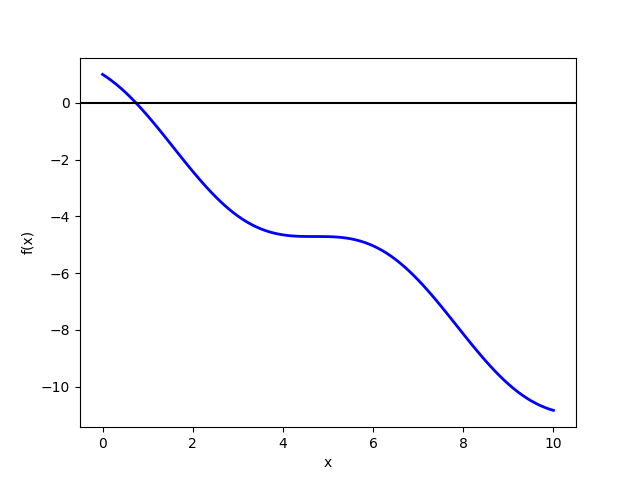

In [4]:
# plot function
%matplotlib notebook
import matplotlib.pyplot as plt
x = np.linspace(0,10,101)
plt.plot(x, myfunc(x), 'b-', linewidth=2)
plt.axhline(y=0, xmin=0, xmax=1, color='k')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

In [5]:
false_position(myfunc, 0., 2., 1e-9, 100)

iteration 1 : approximate location of root at 0.585454927933
root is now brackted by [ 0.585454927933 , 2.0 ]
iteration 2 : approximate location of root at 0.717134868255
root is now brackted by [ 0.717134868255 , 2.0 ]
iteration 3 : approximate location of root at 0.7362556832
root is now brackted by [ 0.7362556832 , 2.0 ]
iteration 4 : approximate location of root at 0.738726105794
root is now brackted by [ 0.738726105794 , 2.0 ]
iteration 5 : approximate location of root at 0.739039669706
root is now brackted by [ 0.739039669706 , 2.0 ]
iteration 6 : approximate location of root at 0.739079377687
root is now brackted by [ 0.739079377687 , 2.0 ]
iteration 7 : approximate location of root at 0.739084404609
root is now brackted by [ 0.739084404609 , 2.0 ]
iteration 8 : approximate location of root at 0.739085040979
root is now brackted by [ 0.739085040979 , 2.0 ]
iteration 9 : approximate location of root at 0.739085121539
root is now brackted by [ 0.739085121539 , 2.0 ]
iteration 10 :

## 5. A more stubborn example

In [7]:
# define function whose roots we are searching for
def myfunc2(x):
    return np.exp(-x) - 1

<IPython.core.display.Javascript object>


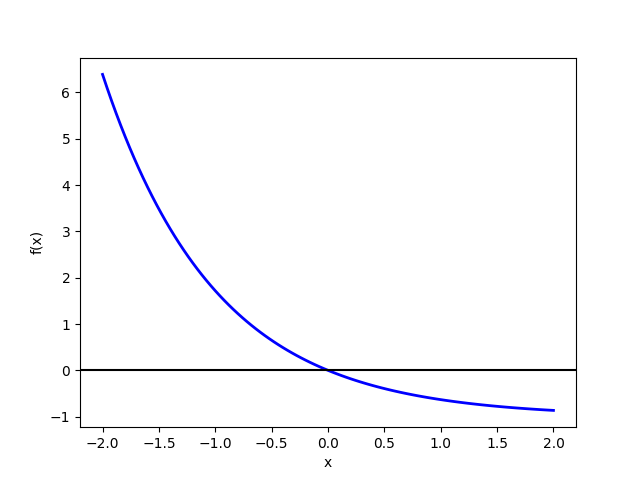

In [8]:
# plot function
%matplotlib notebook
import matplotlib.pyplot as plt
x = np.linspace(-2,2,101)
plt.plot(x, myfunc2(x), 'b-', linewidth=2)
plt.axhline(y=0, xmin=0, xmax=1, color='k')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

In [8]:
false_position(myfunc2, -1, 1, 1e-7, 100)

iteration 1 : approximate location of root at 0.46211715726
root is now brackted by [ -1 , 0.46211715726 ]
iteration 2 : approximate location of root at 0.203030831979
root is now brackted by [ -1 , 0.203030831979 ]
iteration 3 : approximate location of root at 0.0868111290058
root is now brackted by [ -1 , 0.0868111290058 ]
iteration 4 : approximate location of root at 0.036646538125
root is now brackted by [ -1 , 0.036646538125 ]
iteration 5 : approximate location of root at 0.0153830229234
root is now brackted by [ -1 , 0.0153830229234 ]
iteration 6 : approximate location of root at 0.00644174012773
root is now brackted by [ -1 , 0.00644174012773 ]
iteration 7 : approximate location of root at 0.00269477630035
root is now brackted by [ -1 , 0.00269477630035 ]
iteration 8 : approximate location of root at 0.00112682565296
root is now brackted by [ -1 , 0.00112682565296 ]
iteration 9 : approximate location of root at 0.000471099943012
root is now brackted by [ -1 , 0.000471099943012 ]

## 6. Refinements

Comparison of the method of false position with bisection and secant methods in the previous two examples should bear out a common theme: false position converges faster than bisection, but slower than secant (in cases when secant method converges at all).

Examination of the updated brackets will reveal that in cases when false position converges slowly, the method gets stuck in a stationary iteration. That is, rather than alternating between updating the left and right end points, one end point remains fixed for many iterations.

One can break out of this pattern by nudging the root of the secant line closer to the actual root of the function. This is done by shifting the $y$-intercept of the line, which leads to the following modified false position equations. If the right end point is the sticking point, use

\begin{align}
  p_{i} = \frac{\alpha a_{i-1}}{\alpha f(b_{i-1}) - f(a_{i-1})}f(b_{i-1}) 
  + \frac{b_{i-1}}{f(a_{i-1}) - \alpha f(b_{i-1})}f(a_{i-1}),
\end{align}

where $0 \leq \alpha \leq 1$. If instead the left end point is the sticking point, use

\begin{align}
  p_{i} = \frac{a_{i-1}}{f(b_{i-1}) - \alpha f(a_{i-1})}f(b_{i-1}) 
  + \frac{\alpha b_{i-1}}{\alpha f(a_{i-1}) - f(b_{i-1})}f(a_{i-1}).
\end{align}

Note that $\alpha=1$ corresponds to the standard method of false position. The simplest non-standard choice is $\alpha=1/2$, which corresponds to the *Illinois method*. A more complicated scheme was developed by Anderson and Bjork:

\begin{align}
  \alpha =
  \left\{\begin{array}{ll}
    1 - \frac{f(p_{i})}{f(b_{i})} & \quad,\quad \text{if positive} \\
    1/2 & \quad,\quad \text{otherwise}
  \end{array}\right.
\end{align}

For more refinements and variations, see *Numerical Recipes* [4].